<a href="https://colab.research.google.com/github/Oliver-Borg/RLEx1/blob/main/L171_Exercise_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# L171 - Exercise 1: Solving a Rubik's cube with Deep Q-Learning

Welcome to the first exercise for L171: Reinforcement Learning class!

Today, we will work through practical exercises on Deep Q-learning (DQN) to apply the concepts you have learnt in class. Completing these exercises is important preparation for both your tests and the mini-project.

> ❗ IMPORTANT: will discuss these exercises in class on **27/10/2025** (week 3). You do **not** need to submit anything.

While we cannot give you the answers before our class meeting, you are encouraged to discuss the exercise with your friends.

# Installation Part 1 - Read CAREFULLY❗

**First: Set Your Runtime to GPU**

Before you do anything else, you must enable GPU acceleration.
1) In the top menu, navigate to Runtime → Change runtime type.
2) A pop-up window will appear. Find the "Hardware accelerator" dropdown menu and select GPU.
3) Click Save.

------

**Second: Run This Cell (~1 min) and Restart the Session**

Now, you can run this installation cell. After it finishes, a message will appear prompting you to restart the session.

⚠️ You MUST restart the session. Click the ❗ "Restart session" button ❗ when it appears. Do not run this installation cell again. After the session has restarted, simply move on to the next cell.

In [1]:
!gdown 1_p4T016W1_YUGU8S1FyarJPmUxiSsyZM
!unzip /content/rl171-ex1.zip -d /content/rl171-ex1/

# Install the code
!pip install -e /content/rl171-ex1

Downloading...
From: https://drive.google.com/uc?id=1_p4T016W1_YUGU8S1FyarJPmUxiSsyZM
To: /content/rl171-ex1.zip
100% 55.1k/55.1k [00:00<00:00, 6.28MB/s]
Archive:  /content/rl171-ex1.zip
  inflating: /content/rl171-ex1/pyproject.toml  
  inflating: /content/rl171-ex1/__MACOSX/._pyproject.toml  
   creating: /content/rl171-ex1/rl171/
  inflating: /content/rl171-ex1/__MACOSX/._rl171  
   creating: /content/rl171-ex1/rl171/cube_utils/
  inflating: /content/rl171-ex1/__MACOSX/rl171/._cube_utils  
  inflating: /content/rl171-ex1/rl171/mujoco_env_cube_only.py  
  inflating: /content/rl171-ex1/__MACOSX/rl171/._mujoco_env_cube_only.py  
  inflating: /content/rl171-ex1/rl171/README.md  
  inflating: /content/rl171-ex1/__MACOSX/rl171/._README.md  
   creating: /content/rl171-ex1/rl171/assets/
  inflating: /content/rl171-ex1/__MACOSX/rl171/._assets  
  inflating: /content/rl171-ex1/rl171/cube_utils/mujoco_xml.py  
  inflating: /content/rl171-ex1/__MACOSX/rl171/cube_utils/._mujoco_xml.py  
  infla

# Installation Part 2

After restarting the session, run the following cell to install the remaining requirements. No further restart is necessary.

In [5]:
# Environments for the course

# Rendering for GColab
# from: https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb#scrollTo=Xqo7pyX-n72M
# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

# for CleanRL
import random
from dataclasses import dataclass

import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tyro
from torch.utils.tensorboard import SummaryWriter
from typing import Callable, Any, NamedTuple
from gymnasium import spaces
from PIL import Image, ImageDraw, ImageFont
import matplotlib.font_manager as fm


# For CleanRL
from __future__ import annotations

import warnings
from abc import ABC, abstractmethod
from collections.abc import Generator
import cv2
import base64
import imageio
from IPython.display import HTML, display



## Not important - CLEAN RL UTILS from https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl_utils/buffers.py ##
def get_obs_shape(
    observation_space: spaces.Space,
) -> tuple[int, ...] | dict[str, tuple[int, ...]]:
    """
    Get the shape of the observation (useful for the buffers).

    :param observation_space:
    :return:
    """
    if isinstance(observation_space, spaces.Box):
        return observation_space.shape
    elif isinstance(observation_space, spaces.Discrete):
        # Observation is an int
        return (1,)
    elif isinstance(observation_space, spaces.MultiDiscrete):
        # Number of discrete features
        return (int(len(observation_space.nvec)),)
    elif isinstance(observation_space, spaces.MultiBinary):
        # Number of binary features
        return observation_space.shape
    elif isinstance(observation_space, spaces.Dict):
        return {key: get_obs_shape(subspace) for (key, subspace) in observation_space.spaces.items()}  # type: ignore[misc]

    else:
        raise NotImplementedError(f"{observation_space} observation space is not supported")

def get_action_dim(action_space: spaces.Space) -> int:
    """
    Get the dimension of the action space.

    :param action_space:
    :return:
    """
    if isinstance(action_space, spaces.Box):
        return int(np.prod(action_space.shape))
    elif isinstance(action_space, spaces.Discrete):
        # Action is an int
        return 1
    elif isinstance(action_space, spaces.MultiDiscrete):
        # Number of discrete actions
        return int(len(action_space.nvec))
    elif isinstance(action_space, spaces.MultiBinary):
        # Number of binary actions
        assert isinstance(
            action_space.n, int
        ), f"Multi-dimensional MultiBinary({action_space.n}) action space is not supported. You can flatten it instead."
        return int(action_space.n)
    else:
        raise NotImplementedError(f"{action_space} action space is not supported")

def get_device(device: torch.device | str = "auto") -> torch.device:
    """
    Retrieve PyTorch device.
    It checks that the requested device is available first.
    For now, it supports only cpu and cuda.
    By default, it tries to use the gpu.

    :param device: One for 'auto', 'cuda', 'cpu'
    :return: Supported Pytorch device
    """
    # Cuda by default
    if device == "auto":
        device = "cuda"
    # Force conversion to torch.device
    device = torch.device(device)

    # Cuda not available
    if device.type == torch.device("cuda").type and not torch.cuda.is_available():
        return torch.device("cpu")

    return device

try:
    # Check memory used by replay buffer when possible
    import psutil
except ImportError:
    psutil = None


def add_text_to_frame(frame: np.ndarray, text: str) -> np.ndarray:
    """Adds text to a single frame (expects an RGB numpy array)."""
    pil_img = Image.fromarray(frame)
    pil_img = pil_img.resize((640, 480))
    pil_img = pil_img.convert("RGBA")
    draw = ImageDraw.Draw(pil_img)

    try:
        font_path = fm.findfont("DejaVu Sans")
        font = ImageFont.truetype(font_path, size=30)
    except Exception:
        font = ImageFont.load_default()

    # Add text with a semi-transparent background for better visibility
    text_position = (15, 15)
    text_bbox = draw.textbbox(text_position, text, font=font)
    # Add a small padding
    bg_bbox = (text_bbox[0]-5, text_bbox[1]-5, text_bbox[2]+5, text_bbox[3]+5)
    draw.rectangle(bg_bbox, fill=(0, 0, 0, 128)) # Black with 50% opacity
    draw.text(text_position, text, font=font, fill=(255, 255, 255)) # White text

    return np.array(pil_img)

def show_video(frames: list, fps: int = 20):
    """Shows a list of RGB frames as an HTML5 video"""
    if not frames:
        print("No frames to display.")
        return

    # Use imageio to write the frames to a buffer in memory
    # The '<bytes>' URI tells imageio to output to a byte string
    video_bytes = imageio.mimwrite('<bytes>', frames, format='mp4', fps=fps)

    # Encode the video bytes for HTML display
    video_b64 = base64.b64encode(video_bytes).decode()
    html_str = f'<video controls autoplay loop><source src="data:video/mp4;base64,{video_b64}" type="video/mp4"></video>'
    display(HTML(html_str))

FPS = 15 # frames per second



Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:


ModuleNotFoundError: No module named 'mujoco'

# Cube Environment

We will begin by defining and loading a simple environment: a virtual [Rubik's cube](https://en.wikipedia.org/wiki/Rubik's_Cube). The goal is to arrange the cube so that each of its six faces has a single colour. Your objective is to train a DQN agent to solve a scrambled cube.

The image below shows three sides of a solved cube.

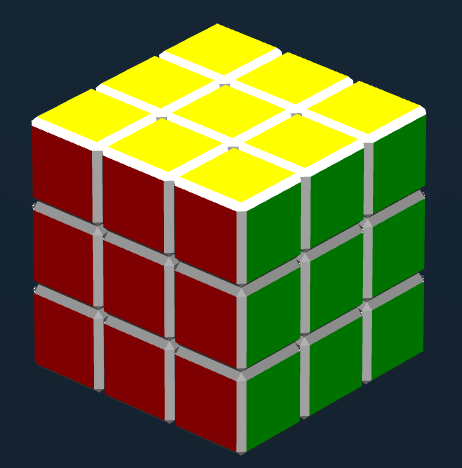

------
## Observations

The environment's observation is a one-dimensional vector of 54 integers that numerically represents the cube's state. The vector's 54 entries correspond to the 9 squares on each of the 6 faces (9 squares * 6 faces = 54). Each integer represents a specific color, as defined by the following mapping:

| Color | Value |
| :--- | :--- |
| `white` | 0 |
| `yellow`| 1 |
| `green` | 2 |
| `blue` | 3 |
| `red` | 4 |
| `orange`| 5 |

To ensure consistency, the faces are always serialized in the same sequence: Up, Left, Front, Right, Back, and Down.

---

## Actions

The agent can perform 12 distinct actions to manipulate the cube. These actions correspond to the standard notation for Rubik's Cube moves, where each letter represents a face and an apostrophe (`'`) indicates a counter-clockwise turn.

* **L, L'**: Turn the **Left** face clockwise or counter-clockwise.
* **R, R'**: Turn the **Right** face clockwise or counter-clockwise.
* **F, F'**: Turn the **Front** face clockwise or counter-clockwise.
* **B, B'**: Turn the **Back** face clockwise or counter-clockwise.
* **D, D'**: Turn the **Down** face clockwise or counter-clockwise.
* **U, U'**: Turn the **Up** face clockwise or counter-clockwise.

Further details on this notation are available at https://ruwix.com/the-rubiks-cube/notation/.

---

## Reward

The reward function is structured to guide the agent toward solving the cube efficiently. The reward at each step is the sum of three components:

    * +5 points for each new face that becomes solved.
    * -5 points for each previously solved face that is un-solved.
    * +50 points are awarded at the moment the entire cube is solved.
    * -0.1 points for every move. This incentivizes the agent to find the most efficient solution.

The code in the next cell provides a basic demonstration. The code start with a solved cube, takes two random actions to show how the state changes. Feel free to play around with the cube to get used to the environment!

In [ ]:
#@title Demo
from rl171.mujoco_env_cube_only import CubeGymEnv

# Define the 12 possible face rotations using standard Rubik's Cube notation
# (e.g., "L" is a clockwise turn of the left face).
# See: https://ruwix.com/the-rubiks-cube/notation/
PYCUBER_ACTIONS = ["L", "L'", "R", "R'", "F", "F'", "B", "B'", "D", "D'", "U", "U'"]

# For this demo, we take two random questions to see how the cube changes.
demo_actions = [6, 2, 3, 7] # indices of the action we want to take, as in PYCUBER_ACTIONS
nr_timesteps = len(demo_actions)

# The environment is configured with the following key parameters:

# 'render_mode': Controls how the cube is visualized.
#   - 'rgb_array': Returns an RGB image of the cube's state. This is useful
#     for saving frames to create a video of the agent's solution.
#   - 'human': Opens an interactive window to display the cube. This is ideal
#     for live observation when running the script locally (requires
#     running the script with 'mjpython').
#
#   **NOTE**: The 'demo' mode, which animates face movements, used below should NOT
#   be used for training. It relies on interpolation and is unstable for
#   complex move sequences.

# 'max_time_steps': Sets the maximum number of moves the agent is allowed
#   per episode. The episode ends if this limit is reached (`truncated` = True).

# 'num_scramble_steps': Defines the number of random moves applied to a
#   solved cube to create its initial, scrambled starting position.
env = CubeGymEnv(render_mode="demo", max_time_steps=100, num_scramble_steps=0)

truncated = False
terminated = False

frames = [] # for rendering (video)
obs, _ = env.reset() # bring the cube to its initial position

### for rendering (video) ###
initial_frames = env.render()
processed_initial_frame = add_text_to_frame(initial_frames[0], "Initial State")
# Duplicate the initial frame to hold it for ~1 seconds
frames.extend([processed_initial_frame] * FPS)
######

for t in range(nr_timesteps):

  action = demo_actions[t]

  # Simulate the action on the cube.
  obs, reward, terminated, truncated, info = env.step(action)

  ### for rendering (video) ###
  animation_frames = env.render()
  animation_frames = [
      add_text_to_frame(frame, f"Action: {PYCUBER_ACTIONS[action]}") for frame in animation_frames
  ]
  frames.extend(animation_frames)
  ######

  if truncated or terminated:
    ### for rendering (video) ###
    end_frame = add_text_to_frame(animation_frames[-1], "Episode End / Reset")
    frames.extend([end_frame] * FPS)
    ######

    obs, info = env.reset()

### for rendering (video) ###
show_video(frames, fps=FPS)
###

env.close()

The video above should be about 7 seconds long. It shows the cube starting in its solved state, then applying two random actions and immediately undoing them to return the cube to its solved position.

# EXERCISES: FILL THE GAPS

The code cells below are incomplete. Your task is to fill in the missing lines (marked with a `TODO`) to complete the exercise. ❗ Familiarise yourself with the rest of the code. It may come in handy❗

The exercise is heavily based on code by [CleanRL](https://docs.cleanrl.dev/). While checking the source code can give you most of the answers, please do not simply copy and paste, as it would defeat the purpose of the exercise. The document is designed to help you start thinking about the concepts we have covered in class. Looking up the solution and copying it will not help you prepare for our in-class discussion or future assessment.

# Replay buffers

The RL, an agent often benefits from remembering its past experiences. A replay buffer is a data structure storing these experiences so the agent can learn from them later.

**Why is Experience Replay Useful in DQN?**

Think back to our lecture. We discussed two key reasons why experience replay is crucial for training a stable and effective DQN agent. Can you recall them?
1) We can shuffle the previously sampled data to break short term correlations in the data. This prevents the agent from learning short term patterns and helps the agent to generalize better.
2) The agent is able to learn from past policies which leads to a better data distribution. (Not only learning from the current policy)

The cell below contains the basic structure of a Replay Buffer, based on the implemention from CleanRL. If you have not worked with replay buffers before, please take a look at the code. Otherwise, feel free to jump to the next cell!

There is nothing for you to complete in the following cell. Ensure you understand the basic structure of a Replay Buffer. It may help later on!


In [ ]:
class ReplayBufferSamples(NamedTuple):
    observations: torch.Tensor
    actions: torch.Tensor
    next_observations: torch.Tensor
    dones: torch.Tensor
    rewards: torch.Tensor

class BaseBuffer(ABC):
    """
    Base class that represent a buffer (rollout or replay)

    :param buffer_size: Max number of element in the buffer
    :param observation_space: Observation space
    :param action_space: Action space
    :param device: PyTorch device
        to which the values will be converted
    :param n_envs: Number of parallel environments
    """

    observation_space: spaces.Space
    obs_shape: tuple[int, ...]

    def __init__(
        self,
        buffer_size: int,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        device: torch.device | str = "auto",
        n_envs: int = 1,
    ):
        super().__init__()
        self.buffer_size = buffer_size
        self.observation_space = observation_space
        self.action_space = action_space
        self.obs_shape = get_obs_shape(observation_space)  # type: ignore[assignment]

        self.action_dim = get_action_dim(action_space)
        self.pos = 0
        self.full = False
        self.device = get_device(device)
        self.n_envs = n_envs

    @staticmethod
    def swap_and_flatten(arr: np.ndarray) -> np.ndarray:
        """
        Swap and then flatten axes 0 (buffer_size) and 1 (n_envs)
        to convert shape from [n_steps, n_envs, ...] (when ... is the shape of the features)
        to [n_steps * n_envs, ...] (which maintain the order)

        :param arr:
        :return:
        """
        shape = arr.shape
        if len(shape) < 3:
            shape = (*shape, 1)
        return arr.swapaxes(0, 1).reshape(shape[0] * shape[1], *shape[2:])

    def size(self) -> int:
        """
        :return: The current size of the buffer
        """
        if self.full:
            return self.buffer_size
        return self.pos

    def add(self, *args, **kwargs) -> None:
        """
        Add elements to the buffer.
        """
        # Ignore NotImplementedError. This is an abstract class, and this
        # exception is raised only if a class inheriting from BaseBuffer
        # doesn't implement this function.
        raise NotImplementedError()

    def extend(self, *args, **kwargs) -> None:
        """
        Add a new batch of transitions to the buffer
        """
        # Do a for loop along the batch axis
        for data in zip(*args):
            self.add(*data)

    def reset(self) -> None:
        """
        Reset the buffer.
        """
        self.pos = 0
        self.full = False

    def sample(self, batch_size: int):
        """
        :param batch_size: Number of element to sample
        :return:
        """
        upper_bound = self.buffer_size if self.full else self.pos
        batch_inds = np.random.randint(0, upper_bound, size=batch_size)
        return self._get_samples(batch_inds)

    @abstractmethod
    def _get_samples(self, batch_inds: np.ndarray) -> ReplayBufferSamples | RolloutBufferSamples:
        """
        :param batch_inds:
        :return:
        """
        raise NotImplementedError()

    def to_torch(self, array: np.ndarray, copy: bool = True) -> torch.Tensor:
        """
        Convert a numpy array to a PyTorch tensor.
        Note: it copies the data by default

        :param array:
        :param copy: Whether to copy or not the data (may be useful to avoid changing things
            by reference). This argument is inoperative if the device is not the CPU.
        :return:
        """
        if copy:
            return torch.tensor(array, device=self.device)
        return torch.as_tensor(array, device=self.device)

While the general skeleton is provided by BaseBuffer, there are many different ways an agent could store and retrieve transitions. We could use strategies such as First in, first out (FIFO), uniform random sampling, or others! What does the `ReplayBuffer` below use?

In [ ]:
class ReplayBuffer(BaseBuffer):
    """
    Replay buffer used in off-policy algorithms like SAC/TD3.

    :param buffer_size: Max number of element in the buffer
    :param observation_space: Observation space
    :param action_space: Action space
    :param device: PyTorch device
    :param n_envs: Number of parallel environments
    :param optimize_memory_usage: Enable a memory efficient variant
        of the replay buffer which reduces by almost a factor two the memory used,
        at a cost of more complexity.
        See https://github.com/DLR-RM/stable-baselines3/issues/37#issuecomment-637501195
        and https://github.com/DLR-RM/stable-baselines3/pull/28#issuecomment-637559274
        Cannot be used in combination with handle_timeout_termination.
    :param handle_timeout_termination: Handle timeout termination (due to timelimit)
        separately and treat the task as infinite horizon task.
        https://github.com/DLR-RM/stable-baselines3/issues/284
    """

    observations: np.ndarray
    next_observations: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    dones: np.ndarray
    timeouts: np.ndarray

    def __init__(
        self,
        buffer_size: int,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        device: torch.device | str = "auto",
        n_envs: int = 1,
        optimize_memory_usage: bool = False,
        handle_timeout_termination: bool = True,
    ):
        super().__init__(buffer_size, observation_space, action_space, device, n_envs=n_envs)

        # Adjust buffer size
        self.buffer_size = max(buffer_size // n_envs, 1)

        # Check that the replay buffer can fit into the memory
        if psutil is not None:
            mem_available = psutil.virtual_memory().available

        # there is a bug if both optimize_memory_usage and handle_timeout_termination are true
        # see https://github.com/DLR-RM/stable-baselines3/issues/934
        if optimize_memory_usage and handle_timeout_termination:
            raise ValueError(
                "ReplayBuffer does not support optimize_memory_usage = True "
                "and handle_timeout_termination = True simultaneously."
            )
        self.optimize_memory_usage = optimize_memory_usage

        self.observations = np.zeros((self.buffer_size, self.n_envs, *self.obs_shape), dtype=observation_space.dtype)

        if not optimize_memory_usage:
            # When optimizing memory, `observations` contains also the next observation
            self.next_observations = np.zeros((self.buffer_size, self.n_envs, *self.obs_shape), dtype=observation_space.dtype)

        self.actions = np.zeros(
            (self.buffer_size, self.n_envs, self.action_dim), dtype=self._maybe_cast_dtype(action_space.dtype)
        )

        self.rewards = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.dones = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        # Handle timeouts termination properly if needed
        # see https://github.com/DLR-RM/stable-baselines3/issues/284
        self.handle_timeout_termination = handle_timeout_termination
        self.timeouts = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)

        if psutil is not None:
            total_memory_usage: float = (
                self.observations.nbytes + self.actions.nbytes + self.rewards.nbytes + self.dones.nbytes
            )

            if not optimize_memory_usage:
                total_memory_usage += self.next_observations.nbytes

            if total_memory_usage > mem_available:
                # Convert to GB
                total_memory_usage /= 1e9
                mem_available /= 1e9
                warnings.warn(
                    "This system does not have apparently enough memory to store the complete "
                    f"replay buffer {total_memory_usage:.2f}GB > {mem_available:.2f}GB"
                )

    def add(
        self,
        obs: np.ndarray,
        next_obs: np.ndarray,
        action: np.ndarray,
        reward: np.ndarray,
        done: np.ndarray,
        infos: list[dict[str, Any]],
    ) -> None:
        # Reshape needed when using multiple envs with discrete observations
        # as numpy cannot broadcast (n_discrete,) to (n_discrete, 1)
        if isinstance(self.observation_space, spaces.Discrete):
            obs = obs.reshape((self.n_envs, *self.obs_shape))
            next_obs = next_obs.reshape((self.n_envs, *self.obs_shape))

        # Reshape to handle multi-dim and discrete action spaces, see GH #970 #1392
        action = action.reshape((self.n_envs, self.action_dim))

        # Copy to avoid modification by reference
        self.observations[self.pos] = np.array(obs)

        if self.optimize_memory_usage:
            self.observations[(self.pos + 1) % self.buffer_size] = np.array(next_obs)
        else:
            self.next_observations[self.pos] = np.array(next_obs)

        self.actions[self.pos] = np.array(action)
        self.rewards[self.pos] = np.array(reward)
        self.dones[self.pos] = np.array(done)

        if self.handle_timeout_termination:
            self.timeouts[self.pos] = np.array([info.get("TimeLimit.truncated", False) for info in infos])

        self.pos += 1
        if self.pos == self.buffer_size:
            self.full = True
            self.pos = 0

    def sample(self, batch_size: int) -> ReplayBufferSamples:
        """
        Sample elements from the replay buffer.
        Custom sampling when using memory efficient variant,
        as we should not sample the element with index `self.pos`
        See https://github.com/DLR-RM/stable-baselines3/pull/28#issuecomment-637559274

        :param batch_size: Number of element to sample
        :return:
        """
        if not self.optimize_memory_usage:
            return super().sample(batch_size=batch_size)
        # Do not sample the element with index `self.pos` as the transitions is invalid
        # (we use only one array to store `obs` and `next_obs`)
        if self.full:
            batch_inds = (np.random.randint(1, self.buffer_size, size=batch_size) + self.pos) % self.buffer_size
        else:
            batch_inds = np.random.randint(0, self.pos, size=batch_size)
        return self._get_samples(batch_inds)

    def _get_samples(self, batch_inds: np.ndarray) -> ReplayBufferSamples:
        # Sample randomly the env idx
        env_indices = np.random.randint(0, high=self.n_envs, size=(len(batch_inds),))

        if self.optimize_memory_usage:
            next_obs = self.observations[(batch_inds + 1) % self.buffer_size, env_indices, :]
        else:
            next_obs = self.next_observations[batch_inds, env_indices, :]

        data = (
            self.observations[batch_inds, env_indices, :],
            self.actions[batch_inds, env_indices, :],
            next_obs,
            # Only use dones that are not due to timeouts
            # deactivated by default (timeouts is initialized as an array of False)
            (self.dones[batch_inds, env_indices] * (1 - self.timeouts[batch_inds, env_indices])).reshape(-1, 1),
            self.rewards[batch_inds, env_indices].reshape(-1, 1),
        )
        return ReplayBufferSamples(*tuple(map(self.to_torch, data)))

    @staticmethod
    def _maybe_cast_dtype(dtype: np.typing.DTypeLike) -> np.typing.DTypeLike:
        """
        Cast `np.float64` action datatype to `np.float32`,
        keep the others dtype unchanged.
        See GH#1572 for more information.

        :param dtype: The original action space dtype
        :return: ``np.float32`` if the dtype was float64,
            the original dtype otherwise.
        """
        if dtype == np.float64:
            return np.float32
        return dtype

#DQN: Setup

We first define some hyperparameters for the algorithm.



In [ ]:
# docs and experiment results can be found at https://docs.cleanrl.dev/rl-algorithms/dqn/#dqnpy

@dataclass
class Args:
    # Feel free to modify these parameters
    num_scramble_steps: int = 1
    """number of initial scramble steps for the cube environment"""
    max_time_steps: int = 5
    """max time steps per episode"""
    total_timesteps: int = 50000
    """total timesteps of the experiments"""
    learning_rate: float = 2.5e-4
    """the learning rate of the optimizer"""
    seed: int = 1
    """seed of the experiment"""
    buffer_size: int = 10000
    """the replay memory buffer size"""
    batch_size: int = 128
    """the batch size of sample from the reply memory"""
    start_e: float = 1
    """the starting epsilon for exploration"""
    end_e: float = 0.05
    """the ending epsilon for exploration"""
    exploration_fraction: float = 0.5
    """the fraction of `total-timesteps` it takes from start-e to go end-e"""
    learning_starts: int = 10000
    """timestep to start learning"""
    train_frequency: int = 10
    """the frequency of training"""
    tau: float = 1.0
    """the target network update rate"""
    target_network_frequency: int = 500
    """the timesteps it takes to update the target network"""

    # You should not need to change these
    exp_name: str = "rl171_ex1"
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    num_envs: int = 1
    """the number of parallel game environments"""
    gamma: float = 0.99
    """the discount factor gamma"""




Epsilon-greedy is a fundamental strategy in reinforcement learning designed to solve the exploration-exploitation dilemma.

An agent in a new environment must decide whether to exploit its current knowledge by choosing the action it believes is best, or to explore by trying a random action in the hopes of discovering an even better reward.

The epsilon ($\epsilon$) parameter represents the probability that the agent will choose to explore.
- With a probability of $1 - \epsilon$, the agent acts greedily, choosing the action with the highest estimated Q-value.
- With a probability of $\epsilon$, the agent ignores its knowledge and chooses a completely random action.

This simple rule ensures the agent continues to learn about its environment while also making use of what it already knows. To make learning more effective, the balance between exploration and exploitation should change over time. Initially, when the agent knows little, exploration is more important. As it gains experience, it should increasingly rely on its knowledge. This is achieved through a technique called epsilon decay, where the value of $\epsilon$ is gradually reduced over the training period. For this course, we will use a linear decay schedule, which is implemented in the `linear_schedule` function. While there are exist other decay strategies, the course will only cover the linear one.

The agent's knowledge is learned and stored in a neural network. The code below defines the architecture for our Q-network, which is responsible for approximating the Q-values (the expected rewards) for every possible action in a given state. The $\epsilon$-greedy policy uses these Q-values to make its decisions whenever it chooses to exploit.

In [ ]:
# ALGO LOGIC: initialize agent here:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(np.array(env.single_observation_space.shape).prod(), 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, env.single_action_space.n),
        )

    def forward(self, x):
        return self.network(x)

def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)


# DQN: Training

It will take a few minutes for the agent to train.

In [ ]:
def make_env(max_time_steps, num_scramble_steps, seed):
    """
    Create environment wrapper function
    Args:
        max_time_steps (int): max time steps per episode
        num_scramble_steps (int): how many random moves to scramble the cube at the start of each episode
        seed (int): seed of the experiment

    """

    def thunk():
        env = CubeGymEnv(render_mode="rgb_array",
                                max_time_steps=max_time_steps,
                                num_scramble_steps=num_scramble_steps)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)

        return env

    return thunk

In [ ]:
args = Args()
assert args.num_envs == 1, "vectorized envs are not supported at the moment"
run_name = f"{args.exp_name}__{args.seed}__{int(time.time())}"

# Logger -- more details are in the "Evaluation" section below
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
)

# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

# env setup
envs = gym.vector.SyncVectorEnv(
    [make_env(max_time_steps=args.max_time_steps, seed=args.seed + i,
              num_scramble_steps=args.num_scramble_steps) for i in range(args.num_envs)]
)
assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

q_network = QNetwork(envs).to(device)
optimizer = optim.Adam(q_network.parameters(), lr=args.learning_rate)
target_network = QNetwork(envs).to(device)
target_network.load_state_dict(q_network.state_dict())

rb = ReplayBuffer(
    args.buffer_size,
    envs.single_observation_space,
    envs.single_action_space,
    device,
    handle_timeout_termination=False,
)
start_time = time.time()

# TRY NOT TO MODIFY: start the game
obs, _ = envs.reset(seed=args.seed)
for global_step in range(args.total_timesteps):
    # ALGO LOGIC: put action logic here
    epsilon = linear_schedule(args.start_e, args.end_e, args.exploration_fraction * args.total_timesteps, global_step)
    if random.random() < epsilon:
      # TODO-Done: take a random action. Make sure you understand why/when this line will run.
      # Since the code uses vectorised environments, we provide the main code. You
      # just need to sample the action of a specific environment (i.e., change
      # the `...` part)
      actions = np.array([ np.random.randint(envs.single_action_space.n) for _ in range(envs.num_envs)])
    else:
      q_values = q_network(torch.Tensor(obs).to(device))
      # TODO-Done: Select the action with the highest Q-value from q_values
      actions = np.array([int(q_values.argmax().cpu())])

    # TRY NOT TO MODIFY: execute the game and log data.
    next_obs, rewards, terminations, truncations, infos = envs.step(actions)

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    if "final_info" in infos:
        for info in infos["final_info"]:
            if info and "episode" in info:
                print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)

    # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
    real_next_obs = next_obs.copy()
    for idx, trunc in enumerate(truncations):
        if trunc:
            real_next_obs[idx] = infos["final_observation"][idx]
    rb.add(obs, real_next_obs, actions, rewards, terminations, infos)

    # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
    obs = next_obs

    # ALGO LOGIC: training.
    if global_step > args.learning_starts:
        if global_step % args.train_frequency == 0:
            data = rb.sample(args.batch_size)
            with torch.no_grad():
                target_max, _ = target_network(data.next_observations.float()).max(dim=1)
                # TODO-Done: Calculate the TD target using the Bellman equation
                # Hint: The formula is R + γ * max_a' Q_target(S', a')
                # Hint2: data.dones.flatten() contains whether we reached
                #        a terminal state, where the future reward is 0.
                # Hint3: reduce `args.learning_starts` to a low value for
                #        testing. Otherwise, you have to train for 10k steps
                #        to see if your td_target implemention works
                td_target = data.rewards.squeeze() + args.gamma * target_max * (1 - data.dones.flatten().to(torch.float32))
                td_target = td_target.squeeze()

            old_val = q_network(data.observations.float()).gather(1, data.actions).squeeze()

            # TODO-Done: Calculate the loss
            # Hint: DQN uses the Mean Squared Error (MSE) loss between the TD target and the predicted Q-value.
            loss = torch.mean((td_target - old_val) ** 2)

            if global_step % 100 == 0:
                writer.add_scalar("losses/td_loss", loss, global_step)
                writer.add_scalar("losses/q_values", old_val.mean().item(), global_step)

            # optimize the model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # update target network
        if global_step % args.target_network_frequency == 0:
            for target_network_param, q_network_param in zip(target_network.parameters(), q_network.parameters()):
                # TODO-Done: Perform a soft update of the target network's weights
                # Hint: The formula is τ * Q_network_weights + (1 - τ) * Q_target_weights
                target_network_param.data.copy_(args.tau * q_network_param + (1 - args.tau) * target_network_param)

# Evaluation

Now it is time to test how well our trained agent performs. To get a measure of its capabilities, we evaluate it in a separate test environment without the random exploration used during training. In other words, we set ϵ=0, meaning the agent will always choose the action it believes will yield the highest reward (this is called a greedy or deterministic policy).

We then run the agent for a set number of test episodes (`eval_episodes`) and calculate the average reward per episode. This average gives us an estimate of the agent's performance.

**Note on best practices:** To keep it simple, in this exercise, we evaluate the agent once after training has finished. However, a much better practice is to evaluate the agent periodically during training (e.g., every 1000 steps). This allows you to track learning progress over time, diagnose problems, and save the model at its peak performance.

For a reliable performance measure, an agent must be trained multiple times using different random seeds (e.g., 10 runs). Averaging these results provides a robust estimate of its true capabilities. While we omit this step for simplicity, it is essential for your future projects!

Please also note all the differences from the CleanRL evaluation code in the cell below.

In [ ]:
# Code adapted from https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl_utils/evals/dqn_eval.py

def evaluate(
    model_path: str,
    make_env: Callable,
    eval_episodes: int,
    run_name: str,
    Model: torch.nn.Module,
    device: torch.device = torch.device("cpu"),
    epsilon: float = 0.00,
    capture_video: bool = True,
):

    episodic_returns = []
    for i in range(eval_episodes):
      episode_done = False

      # Unlike CleanRL, we have a different seed for each environment,
      # where each seed is different from those seen during training
      envs = gym.vector.SyncVectorEnv([make_env(max_time_steps=args.max_time_steps,
                                                seed=args.seed+i+42,
                                                num_scramble_steps=args.num_scramble_steps)])
      model = Model(envs).to(device)
      model.load_state_dict(torch.load(model_path, map_location=device))
      model.eval()
      obs, _ = envs.reset()

      while not episode_done:
        if random.random() < epsilon:
            # !!! While the CleanRL repo has a non-zero default noise,
            # you should have a zero epsilon!
            raise NotImplementedError("Evaluation should have no noise!")
        else:
            q_values = model(torch.Tensor(obs).to(device))
            actions = torch.argmax(q_values, dim=1).cpu().numpy()
        next_obs, rewards, terminations, truncations, infos = envs.step(actions)

        if "final_info" in infos:
            for info in infos["final_info"]:
                if "episode" not in info:
                    continue
                print(f"eval_episode={len(episodic_returns)}, episodic_return={info['episode']['r']}")
                episodic_returns += [info["episode"]["r"]]
                episode_done = True
        obs = next_obs

    return episodic_returns

In [ ]:
# We first save the trained model at the end of training and then evaluate it using the function above
model_path = f"runs/{run_name}/{args.exp_name}.cleanrl_model"
torch.save(q_network.state_dict(), model_path)
print(f"model saved to {model_path}")

episodic_returns = evaluate(
            model_path,
            make_env,
            eval_episodes=10,
            run_name=f"{run_name}-eval",
            Model=QNetwork,
            device=device,
        )
for idx, episodic_return in enumerate(episodic_returns):
  writer.add_scalar("eval/episodic_return", episodic_return, idx)

While we above get 10 different returns, we are interested in knowing how our single agent is doing. We thus compute the average and standard deviation of these values.

In [ ]:
print(f"mean returns: {np.mean(episodic_returns)}")
print(f"standard devision of returns: {np.std(episodic_returns)}")

**Note on evaluation:** while we here used standard deviation, there are many more metrics we could use, depending on the question we are asking. `TODO` familiarise yourself with the concepts of:


*   Standard deviation
*   Standard error
*   Confidence intervals
*   Interquartile Mean (IQM)

Ensure you have also read "Deep Reinforcement Learning at the Edge of the Statistical Precipice" (https://arxiv.org/abs/2108.13264), which is one of the required readings!


# Visualizing Training Progress: Learning Curves

We have code to train and evaluate our agent, but how can we tell if (and how well) it is learning over time?

The most important tool for monitoring this is the learning curve. A learning curve is a graph that plots the agent's performance (like its episodic returns) against the number of training steps.

Visualising a learning curve is useful for seeing whether the agent is improving and diagnosing training issues (e.g., a flat curve means the agent is not learning).

In this class, we will use TensorBoard to plot our learning curves. Other excellent tools for this purpose include [Weights & Biases](https://wandb.ai/site).


In [ ]:
%load_ext tensorboard
%tensorboard --logdir "runs"

Now that we trained our agent and saw it learnt we can close the tensorboard writer.

In [ ]:
writer.close()

# Next: Your turn!

So far, the agent has learned to solve the cube when it is only two steps away from the goal. That is a great start! But what happens when the problem gets harder?

First, as an experiment, try setting `num_scramble_steps=30` in the Args class and see how the agent performs.

You will likely observe that the agent struggles to learn anything meaningful. This is a classic challenge in Reinforcement Learning! The agent is grappling with the cube's **high-dimensionality** (a vast number of possible states), the **long-horizon** nature of the task (requiring a long sequence of correct moves to reach the goal), and **sparse rewards** (we only know if an action was useful when we solve some parts of the cube).

------
## Your challenge

Your main challenge is to improve the existing code to solve a cube scrambled with the highest `num_scramble_steps` value you can achieve.

You do **NOT** need to reach a huge number. Solving the cube from 7-10 steps away would be a very good result. The primary goal of this exercise is for you to experiment with different RL components and build an intuition for how they work.

Here are some ideas you could consider to get started:
- Update the replay buffer to have smarter sampling strategy. Popular options include Prioritized Experience Replay (PER; https://arxiv.org/pdf/1511.05952) and Hindsight Experience Replay (HER; https://arxiv.org/abs/1707.01495)
- Train the agent with a "curriculum" , where the agent first masters solving the cube from 1 move away, then 2, then 3, and so on (https://dl.acm.org/doi/pdf/10.1145/1553374.1553380)
- Change the hyperparameters in the `Args` class. The `learning_rate`, `exploration_fraction`, and `max_time_steps` are a good start.
- Beyond the replay buffer, the other core component of DQN is the target network. Familiarise yourself with the idea of a target network and what it does, change its update frequency, etc. The first two pages of the paper that introduced Double DQN (https://arxiv.org/pdf/1509.06461) could be usful. The goal here is not to implement Double DQN, but to use the paper's introduction to grasp the critical role of the target network and the potential issues in the standard DQN algorithm we cover in this course.


Finally, please write down a summary of your experience. The in-class discussion will be based on these notes, so be sure to include:
- What you tried, even if it failed.
- The challenges you faced.
- What you learned about the problem, the RL techniques, or any other thoughts you had.

If you have any feedback regarding this exercise or the course, please submit this (anonynous) form. https://forms.gle/71gj9p8mX91f1sLE6
